In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
from datetime import timedelta

In [2]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the first column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # Strip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    d = d.apply(pd.to_numeric, errors='ignore')
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var))
    d = pd.concat(d).reset_index()
    return d

In [3]:
def d_plot(d, file_name = '240517'):
    fig,axes = plt.subplots(6,6, sharex=True, figsize=(12, 6))
    ks = d.keys()
    for i,ax in enumerate(axes.ravel()):
        k = ks[i+3]
        ax.plot(d['dt'], d[k], lw=.2, c='r')
        date_format = mdates.DateFormatter('%H')
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(k)
        if i>29:
            ax.set_xlabel('Hour [EST]')
        ax.yaxis.set_label_coords(-0.40, 0.5)
    fig.suptitle(str(d.iloc[0]['dt']) + ' − ' + str(d.iloc[-1]['dt']))
    fig.tight_layout()
    plt.savefig('../figures/dash-'+file_name+'.png', dpi=300)

In [4]:
def s_plot(sems, file_name = '240517'):
    fig,axes = plt.subplots(2,5, sharex='all', figsize=(9, 2.5))
    for i,ax in enumerate(axes.ravel()):
        ax.plot(sems['dt'], sems[sem_keys[i]], lw=.5, c='r')
        date_format = mdates.DateFormatter('%H')
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.set_ylabel(sem_keys[i])
        ax.yaxis.set_label_coords(-0.50, 0.5)
        if i>4:
            ax.set_xlabel('Hour [EST]')
    fig.suptitle(str(sems.iloc[0]['dt']) + ' − ' + str(sems.iloc[-1]['dt']))
    fig.tight_layout()
    plt.savefig('../figures/sems-'+file_name+'.png', dpi=300)

In [5]:
def crop(df, start_time, end_time):
    cols = [col for col in df.columns if 'dt' in col]
    for col in cols:
        df = df[(df[col] >= pd.to_datetime(start_time)) & (df[col] <= pd.to_datetime(end_time))]
    return df

In [6]:
def comb_plot(dash, sems, param, hopc, dopc, file_name = '240517', start_time=None, end_time=None):
    fig,axes = plt.subplots(7, sharex='all', figsize=(9, 12))

    if start_time is not None:
        dash = crop(dash, start_time, end_time)
        sems = crop(sems, start_time, end_time)
        param = crop(param, start_time, end_time)
        hopc = crop(hopc, start_time, end_time)
        dopc = crop(dopc, start_time, end_time)

    
    x,y = [],[]
    for i in range(0, len(param)):
            row = param.iloc[i]
            x.extend([row['st_dt'], row['end_dt']])
            y.extend([row['RH_Targ'], row['RH_Targ']])
    
    
    axes[0].plot(x,y, c='black', lw=.5)
    axes[0].scatter(x,y, c='r', s=.1, zorder=100)
    axes[0].set_ylabel('Target RH [%]')
    
    axes[1].plot(sems['dt'], sems['UpSt_Dia'], lw=.5, c='black')
    axes[1].scatter(sems['dt'], sems['UpSt_Dia'], c='r', s=.1, zorder=100)
    axes[1].set_ylabel('Setpoint D$_p$ [nm]')

    '''
    axes[2].plot(sems['dt'], sems['UpSt_Press'], lw=.5, c='black')
    axes[2].scatter(sems['dt'], sems['UpSt_Press'], c='r', s=.1, zorder=100)
    axes[2].set_ylabel('UpSt_Press')
    '''

    axes[2].plot(dash['dt'], dash['HO_Smp'], lw=.5, c='black')
    axes[2].scatter(dash['dt'], dash['HO_Smp'], c='r', s=.1, zorder=100)
    axes[2].set_ylabel('HO_Smp')

    axes[3].plot(dash['dt'], dash['DO_Smp'], lw=.5, c='black')
    axes[3].scatter(dash['dt'], dash['DO_Smp'], c='r', s=.1, zorder=100)
    axes[3].set_ylabel('DO_Smp')


    axes[4].plot(sems['dt'], sems['UpSt_Samp'], lw=.5, c='black')
    axes[4].scatter(sems['dt'], sems['UpSt_Samp'], c='r', s=.1, zorder=100)
    axes[4].set_ylabel('UpSt_Samp')

    lr_dopc = resamp(dopc)

    axes[5].plot(lr_dopc['dt'], lr_dopc['bin_sum'], lw=.5, c='black')
    axes[5].scatter(dopc['dt'], dopc['bin_sum'], s=.1, c='r')
    axes[5].set_ylim([0,10])
    axes[5].set_ylabel('DOPC Counts')

    lr_hopc = resamp(hopc)

    axes[6].plot(lr_hopc['dt'], lr_hopc['bin_sum'], lw=.5, c='black')
    axes[6].scatter(hopc['dt'], hopc['bin_sum'], s=.1, c='r')
    axes[6].set_ylabel('HOPC Counts')
    axes[6].set_ylim([0,10])
    axes[6].set_xlabel('Hour [EST]')

    for i,ax in enumerate(axes.ravel()):
        #ax.plot(sems['dt'], sems[sem_keys[i]], lw=.5, c='r')
        date_format = mdates.DateFormatter('%H')
        ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        #ax.yaxis.set_label_coords(-0.50, 0.5)
    
    fig.suptitle(str(sems.iloc[0]['dt']) + ' − ' + str(sems.iloc[-1]['dt']))
    fig.tight_layout()
    plt.savefig('../figures/composite-'+file_name+'.png', dpi=300)

In [7]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [8]:
def resamp(d):
    d = d.copy()
    d= d.resample('10s', on='dt').sum(numeric_only=True)
    return d.reset_index()

In [9]:
subfolder = '../data/DASH_test-fight-240517/'
dopc = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder=subfolder))
hopc = add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder=subfolder))
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder=subfolder)
dash = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder=subfolder)
param = glob_reader('SAMP_PARAM', '#StartTimeSt', subfolder=subfolder)
comb_plot(dash, sems, param, hopc, dopc, file_name = '240517', start_time = '2024-05-17 12:00:00', end_time = '2024-05-17 15:00:00')
start_time = '2024-01-01 00:00:00'
end_time = '2024-01-01 00:06:00'

ValueError: No objects to concatenate

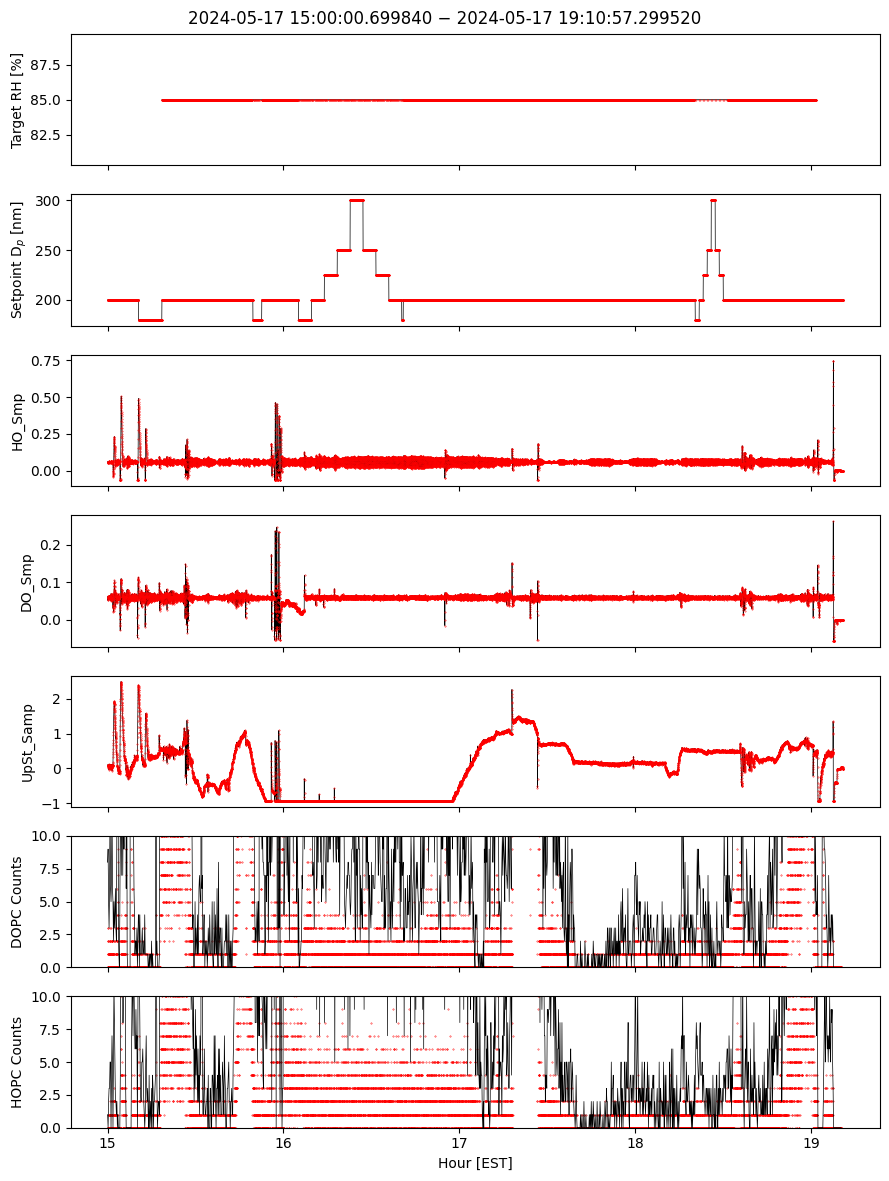

In [ ]:
subfolder = '../data/DASH_test-fight-240517/'
dopc = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder=subfolder))
hopc = add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder=subfolder))
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder=subfolder)
dash = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder=subfolder)
param = glob_reader('SAMP_PARAM', '#StartTimeSt', subfolder=subfolder)
comb_plot(dash, sems, param, hopc, dopc, file_name = '240517_end', start_time = '2024-05-17 15:00:00', end_time = '2024-05-17 19:10:58')
start_time = '2024-01-01 00:00:00'
end_time = '2024-01-01 00:06:00'

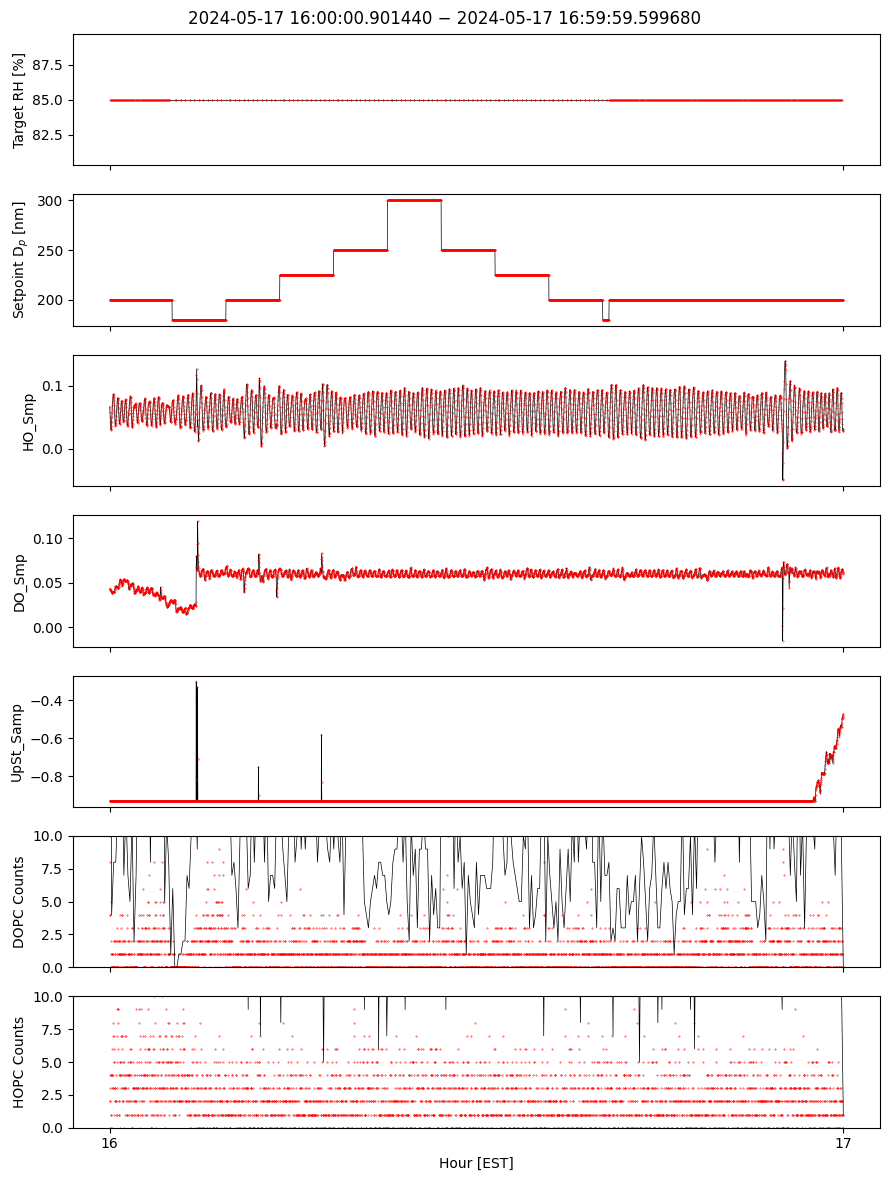

In [ ]:
subfolder = '../data/DASH_test-fight-240517/'
dopc = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder=subfolder))
hopc = add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder=subfolder))
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder=subfolder)
dash = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder=subfolder)
param = glob_reader('SAMP_PARAM', '#StartTimeSt', subfolder=subfolder)
comb_plot(dash, sems, param, hopc, dopc, file_name = '240517_1617', start_time = '2024-05-17 16:00:00', end_time = '2024-05-17 17:00:00')
start_time = '2024-01-01 00:00:00'
end_time = '2024-01-01 00:06:00'

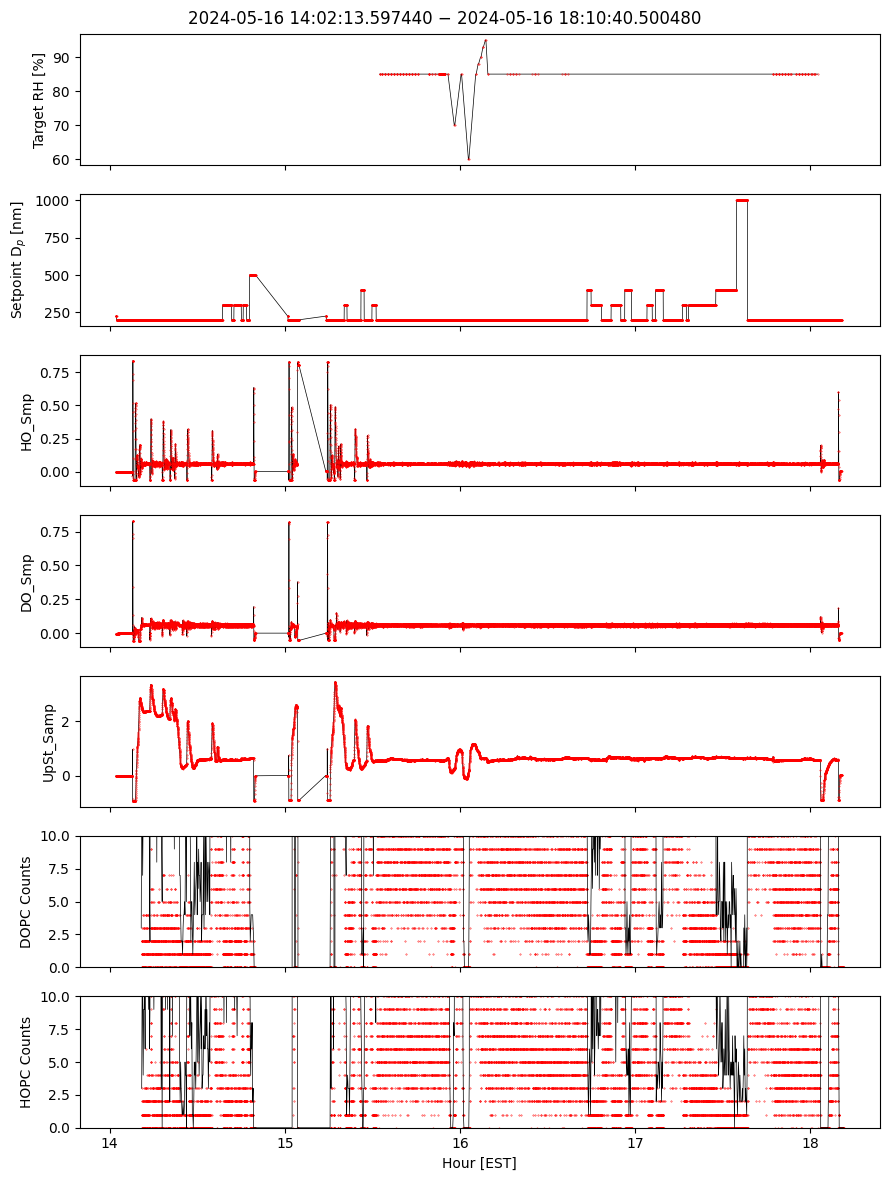

In [ ]:
subfolder = '../data/DASH_test_240516/'
dopc = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder=subfolder))
hopc = add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder=subfolder))
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder=subfolder)
dash = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder=subfolder)
param = glob_reader('SAMP_PARAM', '#StartTimeSt', subfolder=subfolder)
comb_plot(dash, sems, param, hopc, dopc, file_name = '240516')
start_time = '2024-01-01 00:00:00'
end_time = '2024-01-01 00:06:00'

In [ ]:
sems.keys()

Index(['index', 'DOY.Frac', 'YYYY', 'Secs', 'UpSt_Sh', 'UpSt_Xs', 'UpSt_Samp',
       'UpSt_FAdj', 'UpSt_Rh', 'UpSt_T', 'UpSt_Press', 'UpSt_Dia', 'UpSt_HV',
       'dt'],
      dtype='object')

In [ ]:
dash.keys()

Index(['index', 'DOY.Frac', 'YYYY', 'Secs', 'DO_Sh', 'DO_Smp', 'DO_Press',
       'DO_Ht_T', 'DO_Ht_Pwr', 'DO_Fl_T', 'DO_X_T', 'HO_Sh_D_Fl', 'HO_Sh',
       'HO_Smp', 'HO_Press', 'HO_RH', 'HO_T', 'HO_Ht_T', 'HO_Ht_Pwr',
       'HO_Fl_T', 'HO_X_T', 'HO_DP_Cl', 'HO_DP_Lk', 'HM_Sh_D_Fl', 'HM_Sh',
       'HM_Xs', 'HM_Smp_Xs', 'HM_Press', 'HM_RH', 'HM_T', 'HM_Ht_T',
       'HM_Ht_Pwr', 'HM_Fl_T', 'HM_X_T', 'HM_DP_Cl', 'HM_DP_Lk', 'H2O_T',
       'H2O_Pwr', 'H2O_Lvl', 'H2O_Cnt', 'dt'],
      dtype='object')

In [ ]:
day before 5:16

SyntaxError: invalid syntax (3014178506.py, line 1)

In [ ]:
<15

In [ ]:
d = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder='../data/DASH_test-fight-240517/')

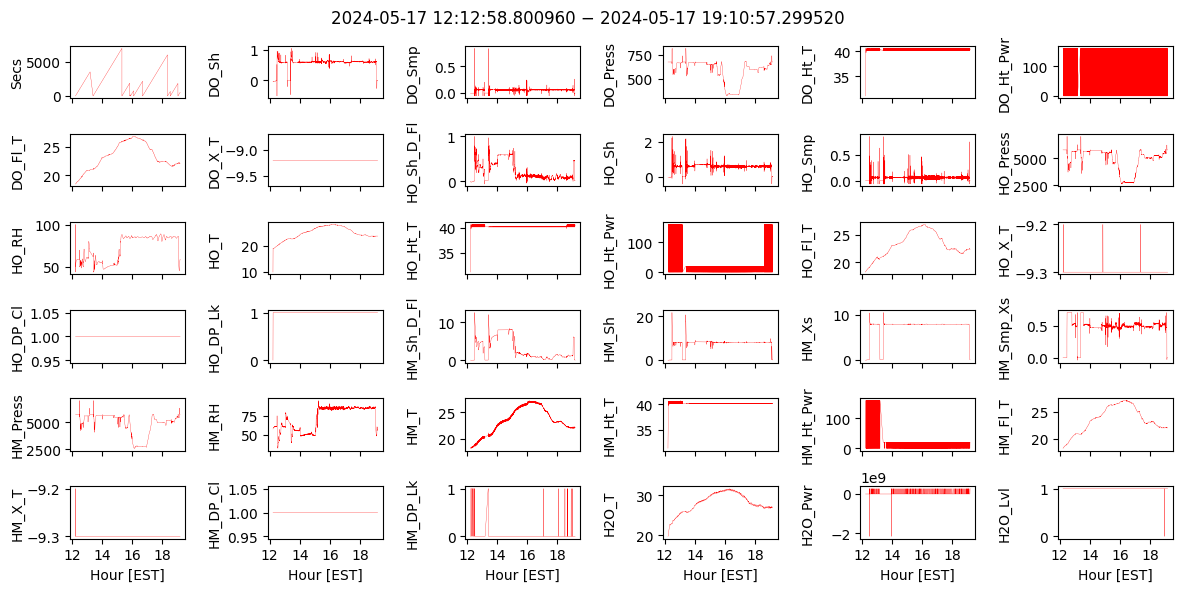

In [ ]:
d_plot(d)

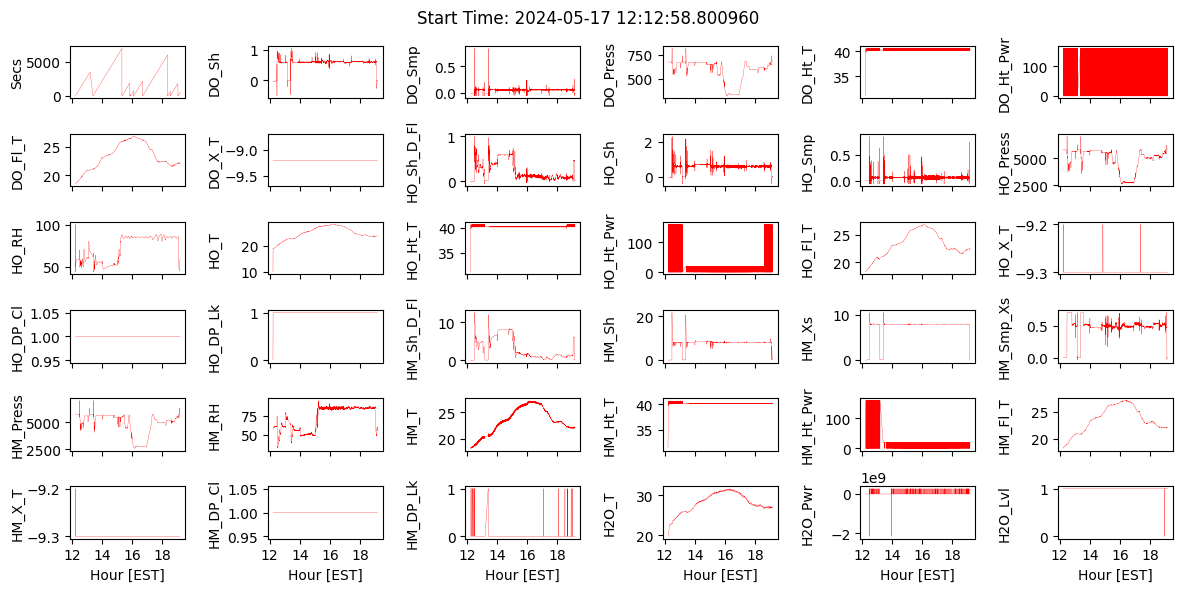

In [ ]:
fig,axes = plt.subplots(6,6, sharex=True, figsize=(12, 6))
ks = d.keys()
for i,ax in enumerate(axes.ravel()):
    k = ks[i+3]
    ax.plot(d['dt'], d[k], lw=.2, c='r')
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.set_ylabel(k)
    if i>29:
        ax.set_xlabel('Hour [EST]')
    ax.yaxis.set_label_coords(-0.40, 0.5)
fig.suptitle('Start Time: ' + str(d.iloc[0]['dt']))
fig.tight_layout()
plt.savefig('../figures/all_240517.png', dpi=300)

In [ ]:
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder='../data/DASH_test-fight-240517/')

In [ ]:
sem_keys = ['Secs', 'UpSt_Sh', 'UpSt_Xs', 'UpSt_Samp',
       'UpSt_FAdj', 'UpSt_Rh', 'UpSt_T', 'UpSt_Press', 'UpSt_Dia', 'UpSt_HV']

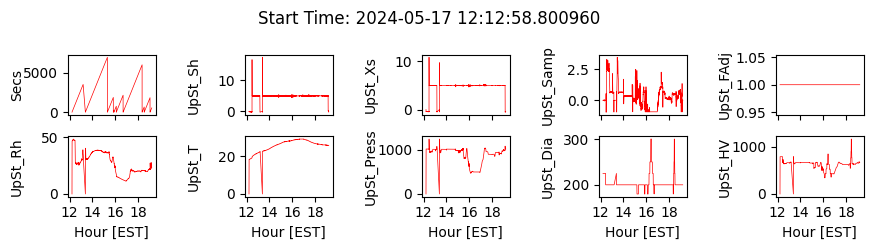

In [ ]:
fig,axes = plt.subplots(2,5, sharex='all', figsize=(9, 2.5))
for i,ax in enumerate(axes.ravel()):
    ax.plot(sems['dt'], sems[sem_keys[i]], lw=.5, c='r')
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.set_ylabel(sem_keys[i])
    ax.yaxis.set_label_coords(-0.50, 0.5)
    if i>4:
        ax.set_xlabel('Hour [EST]')
fig.suptitle('Start Time: ' + str(sems.iloc[0]['dt']))
fig.tight_layout()
plt.savefig('../figures/all_sems_240517.png', dpi=300)

Old

In [ ]:
d = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder='../data/DASH_test_240516/')

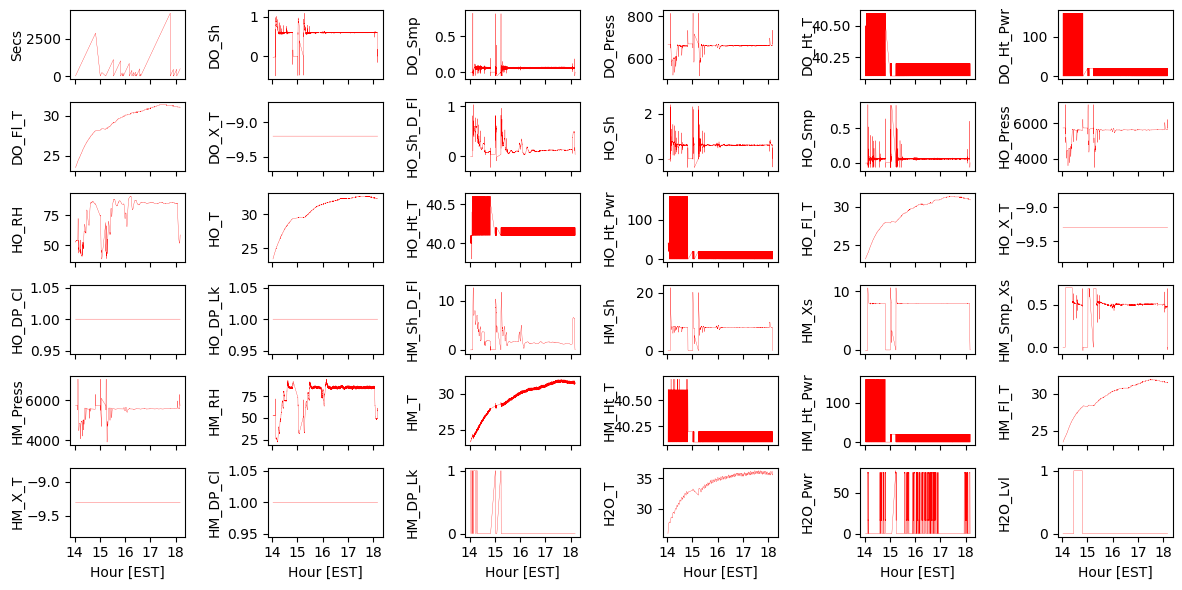

In [ ]:
fig,axes = plt.subplots(6,6, sharex=True, figsize=(12, 6))
ks = d.keys()
for i,ax in enumerate(axes.ravel()):
    k = ks[i+3]
    ax.plot(d['dt'], d[k], lw=.2, c='r')
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_ylabel(k)
    if i>29:
        ax.set_xlabel('Hour [EST]')
    ax.yaxis.set_label_coords(-0.40, 0.5)
fig.tight_layout()
plt.savefig('../figures/all_240516.png', dpi=300)

In [ ]:
sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder='../data/DASH_test_240516/')

In [ ]:
sem_keys = ['Secs', 'UpSt_Sh', 'UpSt_Xs', 'UpSt_Samp',
       'UpSt_FAdj', 'UpSt_Rh', 'UpSt_T', 'UpSt_Press', 'UpSt_Dia', 'UpSt_HV']

In [ ]:
len(sem_keys)

10

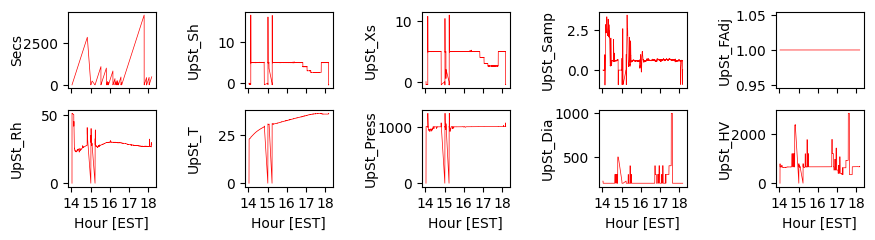

In [ ]:
fig,axes = plt.subplots(2,5, sharex='all', figsize=(9, 2.5))
for i,ax in enumerate(axes.ravel()):
    ax.plot(sems['dt'], sems[sem_keys[i]], lw=.5, c='r')
    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.set_ylabel(sem_keys[i])
    ax.yaxis.set_label_coords(-0.50, 0.5)
    if i>4:
        ax.set_xlabel('Hour [EST]')
fig.tight_layout()
plt.savefig('../figures/all_sems_240516.png', dpi=300)

In [ ]:
def add_bin_sum(d):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [ ]:
def resamp(d):
    d = d.copy()
    
    # Calculate time difference between consecutive points
    d['time_diff'] = d['dt'].diff()
    
    # Introduce NaNs where time difference exceeds 10 minutes
    threshold = timedelta(minutes=1)
    d.loc[d['time_diff'] > threshold, 'dt'] = np.nan
    
    # Forward fill the NaNs in 'dt' to introduce gaps in the resampling
    d['dt'] = d['dt'].ffill()
    
    # Set 'dt' as index for resampling
    d = d.set_index('dt')
    
    # Resample to 1-minute intervals and sum
    d = d.resample('1T').sum(numeric_only=True)
    
    # Reset index to make 'dt' a column again
    return d.reset_index()

In [ ]:
raw = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder='../data/DASH_test_240516/'))

      YY/MM/DD  HR:MN:SC  samp_intrvl  total_conc  sample_flw  sheath_flw  \
0     24/05/16  14:10:57            1         1.0       0.058        0.78   
1     24/05/16  14:10:58            1         2.0       0.060        0.80   
2     24/05/16  14:10:59            1         0.0       0.073        0.82   
3     24/05/16  14:11:00            1         0.0       0.092        0.82   
4     24/05/16  14:11:01            1         1.8       0.100        0.81   
...        ...       ...          ...         ...         ...         ...   
2326  24/05/16  14:49:43            1         0.0      -0.014        0.02   
2327  24/05/16  14:49:44            1         0.0      -0.009        0.01   
2328  24/05/16  14:49:45            1         0.0      -0.005       -0.00   
2329  24/05/16  14:49:46            1         0.0      -0.003       -0.00   
2330  24/05/16  14:49:47            1         0.0      -0.001       -0.01   

      sheath_temp  samp_press  lasr_brt  lasr_cur  ...  bin65  bin66  bin67

In [ ]:
dopc = resamp(add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder='../data/DASH_test_240516/')))

NameError: name 'resamp' is not defined

In [ ]:
hopc = resamp(add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder='../data/DASH_test_240516/')))

NameError: name 'resamp' is not defined

In [ ]:
def low_counts(all_d):
        below_zero = all_d[all_d['bin_sum'] < 20]
        start_points = below_zero.index[~(below_zero.index.to_series().diff() == 1)]
        end_points = below_zero.index[~(below_zero.index.to_series().diff(-1) == -1)]
        return start_points, end_points
def plot_low(axes, all_d, start_points, end_points):
        for i in range(0,4):
                for j in range(0, len(start_points)):
                        axes.axvspan(all_d['dt'].loc[start_points[j]], all_d['dt'].loc[end_points[j]], color='red', alpha=0.2)

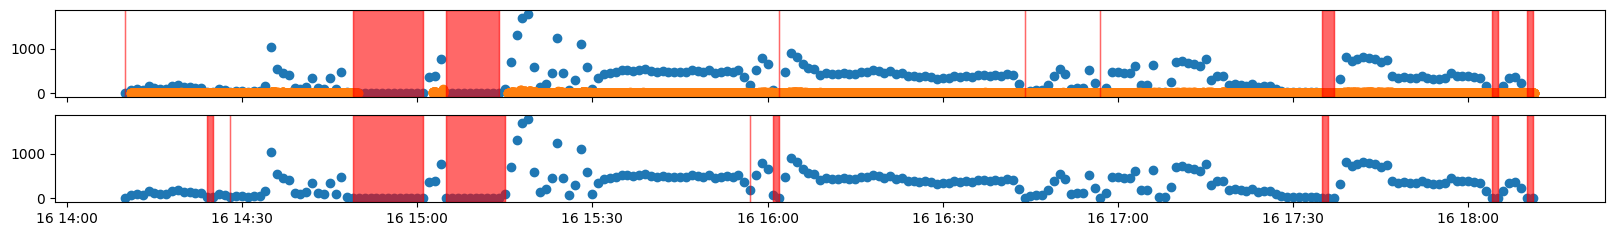

In [ ]:
fig,axes = plt.subplots(2, sharex='all', figsize=(20, 2.5))
axes[0].scatter(dopc['dt'], dopc['bin_sum'])
axes[0].scatter(raw['dt'], raw['bin_sum'])
plot_low(axes[0],dopc, *low_counts(dopc))
axes[1].scatter(dopc['dt'], dopc['bin_sum'])
plot_low(axes[1],hopc, *low_counts(hopc))